# PatchTST Wind Power Prediction Model

This notebook implements a PatchTST (Patching Time Series Transformer) model for 16-point wind power prediction. PatchTST is specifically designed for time series forecasting and is more efficient than traditional Transformers for small datasets.

## Key Features:
- **Patch-based approach**: Divides time series into patches to reduce sequence length
- **Lightweight**: Fewer parameters compared to standard Transformers
- **Small data friendly**: Better performance on limited datasets
- **Attention mechanism**: Captures long-range dependencies effectively

In [1]:
# ===== 超参数配置 =====

class PatchTSTConfig:
    # 数据相关
    seq_length = 96          # 输入序列长度（96个时间点，24小时，每点15分钟）
    pred_length = 16         # 预测序列长度（16个时间点，4小时）
    train_val_split = 0.8    # 训练验证集分割比例
    
    # PatchTST特定参数
    patch_len = 8            # 每个patch的长度（8个时间点）
    stride = 4              # patch之间的步长（不重叠）
    
    # 数据加载
    batch_size = 64          # 减小batch size适应小数据量
    num_workers = 8          # 数据加载器工作进程数
    

    time_interval_minutes = 15
    
    # 滞后特征
    use_feature_engineering = True  # 是否使用特征工程

    add_trend_features = True        # 趋势特征

    add_lag_features = True        # 添加滞后特征
    lag_steps = [1, 2, 4, 8, 16, 24, 48, 96]  #
    
    add_ramp_features = True       # 添加功率爬坡特征
    ramp_windows = [4, 8, 16]       # 爬坡检测窗口

    add_anomaly_features = True      # 异常检测特征
    anomaly_windows = [24, 96]       # 异常检测的滚动窗口大小

    add_statistical_features = True  # 统计滚动特征
    statistical_windows = [4, 8, 16, 24, 48, 96]  # 统计特征的滚动窗口大小
    enable_rolling_mean = True       # 启用滚动均值
    enable_rolling_std = True        # 启用滚动标准差
    enable_rolling_max = True        # 启用滚动最大值
    enable_rolling_min = True        # 启用滚动最小值
    enable_rolling_range = True      # 启用滚动范围
    
    # Transformer模型结构
    d_model = 64            # Transformer维度（较小以适应小数据）
    nhead = 8                # 注意力头数
    num_encoder_layers = 2   # 编码器层数
    dim_feedforward = 256    # FFN维度
    dropout = 0.15           # 增加dropout防止过拟合
    activation = 'gelu'      # 激活函数
    
    # 训练相关
    num_epochs = 500         # 训练轮数
    learning_rate = 0.01   # Learning rate

    # 学习率调度
    lr_patience = 8          # 学习率调度耐心值
    lr_factor = 0.5          # 学习率衰减因子
    
    # 早停机制
    early_stop_patience = 20 # 早停耐心值
    early_stop_min_delta = 0.0001
    
    # 其他
    random_seed = 42
    gpu_device = '7'
    print_freq = 50
    
    # 路径配置
    data_dir = '../data'
    model_save_dir = './models'
    results_dir = './results'

# 创建配置实例
config = PatchTSTConfig()

print("=== PatchTST Configuration ===")
print(f"Time Configuration: {config.seq_length} points -> {config.pred_length} points")
print(f"Patch Configuration: patch_len={config.patch_len}, stride={config.stride}")
print(f"Patch Count: {config.seq_length // config.patch_len}")
print(f"Model: d_model={config.d_model}, nhead={config.nhead}, layers={config.num_encoder_layers}")
print(f"Training: batch_size={config.batch_size}, lr={config.learning_rate}, epochs={config.num_epochs}")
print("=" * 50)

=== PatchTST Configuration ===
Time Configuration: 96 points -> 16 points
Patch Configuration: patch_len=8, stride=4
Patch Count: 12
Model: d_model=64, nhead=8, layers=2
Training: batch_size=64, lr=0.01, epochs=500


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import warnings
warnings.filterwarnings('ignore')

# GPU设置
os.environ['CUDA_VISIBLE_DEVICES'] = config.gpu_device

# 设置随机种子
np.random.seed(config.random_seed)
torch.manual_seed(config.random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(config.random_seed)
    torch.cuda.manual_seed_all(config.random_seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device} (GPU {config.gpu_device})')
if torch.cuda.is_available():
    print(f'GPU device: {torch.cuda.get_device_name(0)}')
    print(f'GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB')

Using device: cuda (GPU 7)
GPU device: NVIDIA RTX A6000
GPU memory: 47.44 GB


In [3]:
# 位置编码模块
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# PatchTST模型定义
class PatchTST(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_len = config.patch_len
        self.stride = config.stride
        self.pred_len = config.pred_length
        
        # 计算patch数量
        self.patch_num = (config.seq_length - config.patch_len) // config.stride + 1
        
        # 输入特征维度（将在数据加载时动态设置）
        self.input_size = getattr(config, 'input_size', 1)
        
        # Patch embedding: 将每个patch映射到d_model维度
        self.patch_embedding = nn.Linear(config.patch_len * self.input_size, config.d_model)
        
        # 位置编码
        self.pos_encoding = PositionalEncoding(config.d_model, config.dropout)
        
        # Transformer编码器
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=config.d_model,
            nhead=config.nhead,
            dim_feedforward=config.dim_feedforward,
            dropout=config.dropout,
            activation=config.activation,
            batch_first=True,
            norm_first=True  # Pre-LN结构，更稳定
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, 
            num_layers=config.num_encoder_layers
        )
        
        # 全局平均池化
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        
        # 输出投影层
        self.output_projection = nn.Sequential(
            nn.Linear(config.d_model, config.d_model // 2),
            nn.GELU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_model // 2, config.pred_length)
        )
        
        # 残差连接（可选）
        self.use_residual = True
        if self.use_residual:
            self.residual_projection = nn.Linear(self.input_size, config.pred_length)
        
        self._init_weights()
    
    def _init_weights(self):
        """权重初始化"""
        for name, param in self.named_parameters():
            if 'weight' in name and param.dim() > 1:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)
    
    def update_input_size(self, input_size):
        """动态更新输入特征维度"""
        self.input_size = input_size
        self.patch_embedding = nn.Linear(
            self.config.patch_len * input_size, 
            self.config.d_model
        ).to(next(self.parameters()).device)
        
        if self.use_residual:
            self.residual_projection = nn.Linear(
                input_size, 
                self.config.pred_length
            ).to(next(self.parameters()).device)
        
        # 重新初始化新层的权重
        nn.init.xavier_uniform_(self.patch_embedding.weight)
        nn.init.constant_(self.patch_embedding.bias, 0)
        if self.use_residual:
            nn.init.xavier_uniform_(self.residual_projection.weight)
            nn.init.constant_(self.residual_projection.bias, 0)
    
    def forward(self, x):
        # x: [batch_size, seq_len, input_size]
        batch_size, seq_len, input_size = x.shape
        
        # 创建patches
        patches = []
        for i in range(0, seq_len - self.patch_len + 1, self.stride):
            patch = x[:, i:i + self.patch_len, :].reshape(batch_size, -1)
            patches.append(patch)
        
        if not patches:
            raise ValueError(f"No patches created. seq_len={seq_len}, patch_len={self.patch_len}")
        
        # 堆叠patches: [batch_size, patch_num, patch_len * input_size]
        patches = torch.stack(patches, dim=1)
        
        # Patch embedding: [batch_size, patch_num, d_model]
        patch_embeddings = self.patch_embedding(patches)
        
        # 位置编码
        patch_embeddings = self.pos_encoding(patch_embeddings)
        
        # Transformer编码
        encoded = self.transformer_encoder(patch_embeddings)
        
        # 全局平均池化: [batch_size, d_model]
        encoded = encoded.transpose(1, 2)  # [batch_size, d_model, patch_num]
        pooled = self.global_avg_pool(encoded).squeeze(-1)  # [batch_size, d_model]
        
        # 输出投影
        output = self.output_projection(pooled)  # [batch_size, pred_length]
        
        # 残差连接（使用输入序列的最后一个值）
        if self.use_residual:
            residual = self.residual_projection(x[:, -1, :])
            output = output + 0.1 * residual  # 较小的残差权重
        
        return output

print("PatchTST model class defined successfully!")

PatchTST model class defined successfully!


In [4]:
# 数据加载和预处理（复用之前的代码）
train_data = pd.read_excel(f'{config.data_dir}/train.xlsx')
test_data = pd.read_excel(f'{config.data_dir}/test.xlsx')

train_power = train_data.iloc[:, 0].values
test_power = test_data.iloc[:, 0].values

print(f"Training data length: {len(train_power)}")
print(f"Testing data length: {len(test_power)}")
print(f"Training data range: [{train_power.min():.4f}, {train_power.max():.4f}]")
print(f"Testing data range: [{test_power.min():.4f}, {test_power.max():.4f}]")

# 简化的数据预处理
def simplified_data_preprocessing(data, config):
    processed_data = data.copy()
    processed_data = np.where(processed_data < 0, 0, processed_data)
    
    negative_count = np.sum(data < 0)
    if negative_count > 0:
        print(f"Converted {negative_count} negative values to 0")
    else:
        print("No negative values found")
    
    return processed_data, None

print("\n=== Data Preprocessing ===")
train_power_processed, _ = simplified_data_preprocessing(train_power, config)
test_power_processed, _ = simplified_data_preprocessing(test_power, config)

print(f"Final training data range: [{train_power_processed.min():.4f}, {train_power_processed.max():.4f}]")
print(f"Final testing data range: [{test_power_processed.min():.4f}, {test_power_processed.max():.4f}]")

Training data length: 6999
Testing data length: 2999
Training data range: [-0.0094, 1.0000]
Testing data range: [-0.0093, 0.9446]

=== Data Preprocessing ===
Converted 445 negative values to 0
Converted 138 negative values to 0
Final training data range: [0.0000, 1.0000]
Final testing data range: [0.0000, 0.9446]


In [5]:
# 数据集类定义
class EnhancedPowerDataset(Dataset):
    def __init__(self, data, seq_length=96, pred_length=16, step=1, config=None):
        """
        增强的电力数据集类（支持全面特征工程）
        
        参数:
        data: 原始时间序列数据
        seq_length: 输入序列长度
        pred_length: 预测序列长度
        step: 滑动窗口步长
        config: 配置对象
        """
        self.data = data
        self.seq_length = seq_length
        self.pred_length = pred_length
        self.step = step
        self.config = config
        
        # 创建特征
        if config and config.use_feature_engineering:
            self.features, self.feature_names = self._create_enhanced_features()
            print(f"Created {self.features.shape[1]} features: {len(self.feature_names)} total")
            print(f"Feature categories: {self._get_feature_categories()}")
            
            # 特征选择（如果启用）
            if getattr(config, 'enable_feature_selection', False) and self.features.shape[1] > config.max_features:
                self.features, self.feature_names = self._apply_feature_selection()
                print(f"After feature selection: {self.features.shape[1]} features")
        else:
            self.features = data.reshape(-1, 1)
            self.feature_names = ['power']
        
        # 创建输入输出对
        self.X, self.y = self._create_sequences()

    def _get_feature_categories(self):
        """获取特征类别统计"""
        categories = {}
        for name in self.feature_names:
            if name == 'power':
                category = 'original'
            elif name.startswith('lag_'):
                category = 'lag'
            elif name.startswith('ramp_'):
                category = 'ramp'
            elif name.startswith('rolling_'):
                category = 'statistical'
            elif 'outlier' in name or 'anomaly' in name:
                category = 'anomaly'
            elif name.endswith(('_sin', '_cos')) or 'time' in name or 'hour' in name or 'weekday' in name or 'month' in name or 'season' in name:
                category = 'temporal'
            elif name.startswith(('diff_', 'pct_', 'cumulative_', 'relative_')):
                category = 'trend'
            elif name.startswith('power_level_') or name in ['zero_power', 'full_power', 'power_level_change']:
                category = 'power_state'
            elif name.startswith(('volatility_', 'cv_', 'skewness_', 'kurtosis_')):
                category = 'volatility'
            elif name.startswith(('diff_historical_', 'ratio_historical_')) or name == 'is_weekend':
                category = 'cross_temporal'
            elif name in ['dominant_frequency', 'spectral_energy']:
                category = 'frequency'
            else:
                category = 'other'
            
            categories[category] = categories.get(category, 0) + 1
        
        return categories


    def add_trend_features(self, power_series):
        """添加趋势和变化率特征（归一化版本）"""
        features = []
        feature_names = []
        
        # 一阶差分（变化率）- 归一化
        diff_1 = power_series.diff(1).fillna(0)
        # 裁剪到合理范围并归一化到[-1, 1]
        diff_1_normalized = np.clip(diff_1.values, -0.5, 0.5)
        features.append(diff_1_normalized)
        feature_names.append('diff_1')
        
        # 二阶差分（加速度）- 归一化
        diff_2 = power_series.diff(2).fillna(0)
        # 裁剪到合理范围并归一化到[-1, 1]
        diff_2_normalized = np.clip(diff_2.values, -0.3, 0.3)
        features.append(diff_2_normalized)
        feature_names.append('diff_2')
        
        return features, feature_names


    def add_statistical_features(self, power_series):
        """添加统计滚动窗口特征（使用config中的窗口参数）"""
        features = []
        feature_names = []
        
        # 使用config中的统计窗口参数
        windows = self.config.statistical_windows
        
        for window in windows:
            # 滚动均值
            if self.config.enable_rolling_mean:
                rolling_mean = power_series.rolling(window=window, min_periods=1).mean().fillna(0).values
                features.append(rolling_mean)
                feature_names.append(f'rolling_mean_{window}')
            
            # 滚动标准差
            if self.config.enable_rolling_std:
                rolling_std = power_series.rolling(window=window, min_periods=1).std().fillna(0).values
                features.append(rolling_std)
                feature_names.append(f'rolling_std_{window}')
            
            # 滚动最大值
            if self.config.enable_rolling_max:
                rolling_max = power_series.rolling(window=window, min_periods=1).max().fillna(0).values
                features.append(rolling_max)
                feature_names.append(f'rolling_max_{window}')
            
            # 滚动最小值
            if self.config.enable_rolling_min:
                rolling_min = power_series.rolling(window=window, min_periods=1).min().fillna(0).values
                features.append(rolling_min)
                feature_names.append(f'rolling_min_{window}')
            
            # 滚动范围（max - min）
            if self.config.enable_rolling_range and self.config.enable_rolling_max and self.config.enable_rolling_min:
                rolling_max = power_series.rolling(window=window, min_periods=1).max().fillna(0).values
                rolling_min = power_series.rolling(window=window, min_periods=1).min().fillna(0).values
                rolling_range = rolling_max - rolling_min
                features.append(rolling_range)
                feature_names.append(f'rolling_range_{window}')
        
        return features, feature_names

    def add_anomaly_features(self, power_series):
        """添加异常检测特征（使用config中的窗口参数）"""
        features = []
        feature_names = []
        
        # Z-score异常检测
        z_scores = np.abs((power_series - power_series.mean()) / power_series.std())
        is_outlier = (z_scores > 2).astype(int).values  # 2个标准差外为异常
        features.append(is_outlier)
        feature_names.append('is_outlier')
        
        # IQR异常检测
        Q1 = power_series.quantile(0.25)
        Q3 = power_series.quantile(0.75)
        IQR = Q3 - Q1
        is_iqr_outlier = ((power_series < (Q1 - 1.5 * IQR)) | 
                          (power_series > (Q3 + 1.5 * IQR))).astype(int).values
        features.append(is_iqr_outlier)
        feature_names.append('is_iqr_outlier')
        
        # 局部异常因子（使用config中的异常窗口参数）
        windows = self.config.anomaly_windows
        for window in windows:
            local_mean = power_series.rolling(window=window, center=True).mean()
            local_std = power_series.rolling(window=window, center=True).std()
            local_anomaly = np.abs(power_series - local_mean) > (2 * local_std)
            features.append(local_anomaly.fillna(0).astype(int).values)
            feature_names.append(f'local_anomaly_{window}')
        
        return features, feature_names
    
    def _apply_feature_selection(self):
        """应用特征选择"""
        from sklearn.feature_selection import VarianceThreshold
        
        # 方差阈值过滤
        selector = VarianceThreshold(threshold=0.001)
        features_filtered = selector.fit_transform(self.features)
        selected_features = [name for i, name in enumerate(self.feature_names) 
                            if selector.get_support()[i]]
        
        # 如果仍然超过最大特征数，随机选择
        if len(selected_features) > self.config.max_features:
            np.random.seed(self.config.random_seed)
            indices = np.random.choice(len(selected_features), self.config.max_features, replace=False)
            features_filtered = features_filtered[:, indices]
            selected_features = [selected_features[i] for i in indices]
        
        return features_filtered, selected_features
    
    def _create_enhanced_features(self):
        """创建增强的特征（完整版）"""
        features = []
        feature_names = []
        
        power_series = pd.Series(self.data)
        
        # 1. 原始功率数据
        features.append(self.data)
        feature_names.append('power')
        
        # 2. 滞后特征
        if self.config.add_lag_features:
            for lag in self.config.lag_steps:
                if lag < len(self.data):
                    lag_feature = np.roll(self.data, lag)
                    lag_feature[:lag] = lag_feature[lag]
                    features.append(lag_feature)
                    feature_names.append(f'lag_{lag}')
        
        # 3. 功率爬坡特征
        if self.config.add_ramp_features:
            for window in self.config.ramp_windows:
                # 功率爬坡率：单位时间内功率变化幅度
                ramp_rate = power_series.diff(window).fillna(0).values
                features.append(ramp_rate)
                feature_names.append(f'ramp_rate_{window}')
                
                # 绝对爬坡率
                abs_ramp_rate = np.abs(ramp_rate)
                features.append(abs_ramp_rate)
                feature_names.append(f'abs_ramp_rate_{window}')
                
                # 功率爬坡强度（滚动窗口内最大绝对变化）
                ramp_intensity = power_series.diff().abs().rolling(window=window, min_periods=1).max().fillna(0).values
                features.append(ramp_intensity)
                feature_names.append(f'ramp_intensity_{window}')
                
                # 爬坡方向（上升=1，下降=-1，稳定=0）
                ramp_direction = np.sign(ramp_rate)
                features.append(ramp_direction)
                feature_names.append(f'ramp_direction_{window}')
        
        # 4. 统计滚动特征
        if self.config.add_statistical_features:
            stat_features, stat_names = self.add_statistical_features(power_series)
            features.extend(stat_features)
            feature_names.extend(stat_names)

        # 5. 异常检测特征
        if self.config.add_anomaly_features:
            anomaly_features, anomaly_names = self.add_anomaly_features(power_series)
            features.extend(anomaly_features)
            feature_names.extend(anomaly_names)
        
        
        # 6. 新增：趋势特征
        if getattr(self.config, 'add_trend_features', True):
            trend_features, trend_names = self.add_trend_features(power_series)
            features.extend(trend_features)
            feature_names.extend(trend_names)
        
    
        return np.array(features).T, feature_names  # [time_steps, num_features]
    
    def _create_sequences(self):
        X, y = [], []
        for i in range(0, len(self.data) - self.seq_length - self.pred_length + 1, self.step):
            # 多特征输入序列
            X.append(self.features[i:i + self.seq_length])
            # 输出序列（仍然是原始功率数据）
            y.append(self.data[i + self.seq_length:i + self.seq_length + self.pred_length])
        return np.array(X), np.array(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.X[idx]), torch.FloatTensor(self.y[idx])




# 创建训练数据集
print("Creating training dataset...")
train_dataset = EnhancedPowerDataset(
    data=train_power_processed,
    seq_length=config.seq_length,
    pred_length=config.pred_length,
    step=1,
    config=config
)

print(f"Training dataset created successfully!")
print(f"Dataset length: {len(train_dataset)}")
print(f"Features shape: {train_dataset.features.shape}")
print(f"Input sequences shape: {train_dataset.X.shape}")
print(f"Target sequences shape: {train_dataset.y.shape}")

# 创建测试数据集
print("\nCreating test dataset...")
test_dataset = EnhancedPowerDataset(
    data=test_power_processed,
    seq_length=config.seq_length,
    pred_length=config.pred_length,
    step=1,
    config=config
)

print(f"Test dataset created successfully!")
print(f"Dataset length: {len(test_dataset)}")
print(f"Features shape: {test_dataset.features.shape}")
print(f"Input sequences shape: {test_dataset.X.shape}")
print(f"Target sequences shape: {test_dataset.y.shape}")

# 更新config中的input_size
config.input_size = train_dataset.features.shape[1]
print(f"\nUpdated config.input_size to: {config.input_size}")


# 检查特征范围（不进行归一化）
print(f"\nFeature Statistics (Raw Features - No Normalization):")
print(f"Features range: [{train_dataset.features.min():.6f}, {train_dataset.features.max():.6f}]")
print(f"Features mean: {train_dataset.features.mean():.6f}")
print(f"Features std: {train_dataset.features.std():.6f}")
print(f"Target values range: [{train_dataset.data.min():.6f}, {train_dataset.data.max():.6f}]")

# 检查是否有异常值
has_nan = np.isnan(train_dataset.features).any()
has_inf = np.isinf(train_dataset.features).any()
has_very_large = np.any(np.abs(train_dataset.features) > 1e6)

print(f"\nData Quality Check:")
print(f"Has NaN values: {has_nan}")
print(f"Has Inf values: {has_inf}")
print(f"Has very large values (>1e6): {has_very_large}")

if has_nan or has_inf or has_very_large:
    print("⚠️  WARNING: Found problematic values in features!")
    print("🔧 Applying safe replacement (NaN/Inf → 0)...")
    train_dataset.features = np.nan_to_num(train_dataset.features, nan=0.0, posinf=0.0, neginf=0.0)
    test_dataset.features = np.nan_to_num(test_dataset.features, nan=0.0, posinf=0.0, neginf=0.0)
    
    # 重新创建序列
    train_dataset.X, train_dataset.y = train_dataset._create_sequences()
    test_dataset.X, test_dataset.y = test_dataset._create_sequences()
    print("✅ Problematic values replaced, sequences recreated")
else:
    print("✅ No problematic values found")



# 创建数据加载器
print("\n" + "="*60)
print("CREATING DATA LOADERS")


# 分割训练集和验证集
train_size = int(config.train_val_split * len(train_dataset))
train_indices = list(range(train_size))
val_indices = list(range(train_size, len(train_dataset)))

train_dataset_split = torch.utils.data.Subset(train_dataset, train_indices)
val_dataset = torch.utils.data.Subset(train_dataset, val_indices)

# 创建数据加载器
train_loader = DataLoader(train_dataset_split, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers)

print(f"Training set size: {len(train_dataset_split)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Testing set size: {len(test_dataset)}")

print(f"Total features: {len(train_dataset.feature_names)}")
print(f"Feature categories: {train_dataset._get_feature_categories()}")
print(f"Ready for training!")

Creating training dataset...
Created 57 features: 57 total
Feature categories: {'original': 1, 'lag': 8, 'ramp': 9, 'other': 3, 'statistical': 30, 'anomaly': 4, 'trend': 2}


Training dataset created successfully!
Dataset length: 6888
Features shape: (6999, 57)
Input sequences shape: (6888, 96, 57)
Target sequences shape: (6888, 16)

Creating test dataset...
Created 57 features: 57 total
Feature categories: {'original': 1, 'lag': 8, 'ramp': 9, 'other': 3, 'statistical': 30, 'anomaly': 4, 'trend': 2}
Test dataset created successfully!
Dataset length: 2888
Features shape: (2999, 57)
Input sequences shape: (2888, 96, 57)
Target sequences shape: (2888, 16)

Updated config.input_size to: 57

Feature Statistics (Raw Features - No Normalization):
Features range: [-1.000000, 1.000000]
Features mean: 0.167196
Features std: 0.321856
Target values range: [0.000000, 1.000000]

Data Quality Check:
Has NaN values: False
Has Inf values: False
Has very large values (>1e6): False
✅ No problematic values found

CREATING DATA LOADERS
Training set size: 5510
Validation set size: 1378
Testing set size: 2888
Total features: 57
Feature categories: {'original': 1, 'lag': 8, 'ramp'

In [6]:
# 创建PatchTST模型
model = PatchTST(config).to(device)

# 更新模型的输入维度
model.update_input_size(config.input_size)

# 模型信息
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"=== PatchTST Model Information ===")
print(f"Input sequence length: {config.seq_length}")
print(f"Patch length: {config.patch_len}")
print(f"Number of patches: {model.patch_num}")
print(f"Input features: {config.input_size}")
print(f"Model dimension: {config.d_model}")
print(f"Attention heads: {config.nhead}")
print(f"Encoder layers: {config.num_encoder_layers}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print("=" * 50)

# 测试前向传播
with torch.no_grad():
    sample_input = torch.randn(2, config.seq_length, config.input_size).to(device)
    sample_output = model(sample_input)
    print(f"Test forward pass - Input shape: {sample_input.shape}, Output shape: {sample_output.shape}")

=== PatchTST Model Information ===
Input sequence length: 96
Patch length: 8
Number of patches: 23
Input features: 57
Model dimension: 64
Attention heads: 8
Encoder layers: 2
Total parameters: 132,752
Trainable parameters: 132,752
Test forward pass - Input shape: torch.Size([2, 96, 57]), Output shape: torch.Size([2, 16])


In [7]:
# 损失函数和优化器
criterion = nn.HuberLoss(delta=1.0)
optimizer = optim.AdamW(
    model.parameters(), 
    lr=config.learning_rate, 
    betas=(0.9, 0.95)  # 适合Transformer的beta值
)

# 学习率调度器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=config.lr_factor, 
    patience=config.lr_patience, verbose=True, min_lr=1e-6
)

# CR指标计算函数
def calculate_CR(PM, PP):
    N = len(PM)
    Ri = np.zeros(N)
    for i in range(N):
        if PM[i] > 0.2:
            Ri[i] = (PM[i] - PP[i]) / PM[i]
        else:
            Ri[i] = (PM[i] - PP[i]) / 0.2
    rms_error = np.sqrt(np.mean(Ri**2))
    CR = (1 - rms_error) * 100
    return CR

# 早停机制
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_cr = None
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, val_cr, model):
        if self.best_cr is None:
            self.best_cr = val_cr
            self.save_checkpoint(model)
        elif val_cr > self.best_cr + self.min_delta:
            self.best_cr = val_cr
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            
        return self.counter >= self.patience
    
    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

early_stopping = EarlyStopping(
    patience=config.early_stop_patience, 
    min_delta=config.early_stop_min_delta
)

print(f"Training setup completed!")
print(f"Optimizer: AdamW (lr={config.learning_rate})")
print(f"Loss function: Huber Loss")
print(f"LR Scheduler: ReduceLROnPlateau (patience={config.lr_patience})")
print(f"Early stopping: patience={config.early_stop_patience}")

Training setup completed!
Optimizer: AdamW (lr=0.01)
Loss function: Huber Loss
LR Scheduler: ReduceLROnPlateau (patience=8)
Early stopping: patience=20


In [8]:
# 训练和验证函数
def train_epoch(model, train_loader, criterion, optimizer, device, config):
    model.train()
    total_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
    
        optimizer.step()
        total_loss += loss.item()
        
        if batch_idx % config.print_freq == 0:
            print(f'  Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.6f}')
    
    return total_loss / len(train_loader)

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
    
    return total_loss / len(val_loader)

def calculate_validation_cr(model, val_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            all_predictions.append(output.cpu().numpy())
            all_targets.append(target.cpu().numpy())
    
    predictions = np.concatenate(all_predictions, axis=0)
    targets = np.concatenate(all_targets, axis=0)
    
    cr_overall = calculate_CR(targets.flatten(), predictions.flatten())
    return cr_overall

print("Training functions defined successfully!")

Training functions defined successfully!


In [9]:
# 开始训练
train_losses = []
val_losses = []
val_cr_scores = []

print("=== Starting PatchTST Training ===")
print(f"Model: PatchTST")
print(f"Training epochs: {config.num_epochs}")
print(f"Batch size: {config.batch_size}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"Patches per sequence: {model.patch_num}")
print("=" * 50)

best_epoch = 0
for epoch in range(config.num_epochs):
    print(f"\nEpoch {epoch+1}/{config.num_epochs}")
    
    # 训练
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device, config)
    train_losses.append(train_loss)
    
    # 验证
    val_loss = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    
    # 计算验证集CR指标
    val_cr = calculate_validation_cr(model, val_loader, device)
    val_cr_scores.append(val_cr)
    
    # 学习率调度
    scheduler.step(val_loss)
    
    print(f"Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
    print(f"Validation CR: {val_cr:.2f}%")
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    # 早停检查
    if early_stopping(val_cr, model):
        print(f"\nEarly stopping triggered! Training stopped at epoch {epoch+1}")
        print(f"Best CR metric: {early_stopping.best_cr:.2f}%")
        best_epoch = epoch + 1
        break
    
    if val_cr == early_stopping.best_cr:
        best_epoch = epoch + 1

print("\n=== Training Completed ===")
print(f"Best validation CR: {early_stopping.best_cr:.2f}% (Epoch {best_epoch})")
print(f"Total epochs trained: {len(train_losses)}")

# 恢复最佳权重
if early_stopping.best_weights is not None:
    model.load_state_dict(early_stopping.best_weights)
    print("Restored best model weights")

=== Starting PatchTST Training ===
Model: PatchTST
Training epochs: 500
Batch size: 64
Learning rate: 0.01
Patches per sequence: 23

Epoch 1/500
  Batch 0/87, Loss: 0.450372
  Batch 50/87, Loss: 0.012652
Train Loss: 0.061774, Val Loss: 0.006046
Validation CR: 59.19%
Current LR: 1.00e-02

Epoch 2/500
  Batch 0/87, Loss: 0.008476
  Batch 50/87, Loss: 0.005891
Train Loss: 0.007736, Val Loss: 0.005500
Validation CR: 59.37%
Current LR: 1.00e-02

Epoch 3/500
  Batch 0/87, Loss: 0.005814
  Batch 50/87, Loss: 0.005564
Train Loss: 0.007271, Val Loss: 0.005168
Validation CR: 61.94%
Current LR: 1.00e-02

Epoch 4/500
  Batch 0/87, Loss: 0.009635
  Batch 50/87, Loss: 0.006789
Train Loss: 0.007109, Val Loss: 0.005019
Validation CR: 63.35%
Current LR: 1.00e-02

Epoch 5/500
  Batch 0/87, Loss: 0.006834
  Batch 50/87, Loss: 0.006918
Train Loss: 0.007095, Val Loss: 0.005276
Validation CR: 59.95%
Current LR: 1.00e-02

Epoch 6/500
  Batch 0/87, Loss: 0.006866
  Batch 50/87, Loss: 0.007872
Train Loss: 0.00

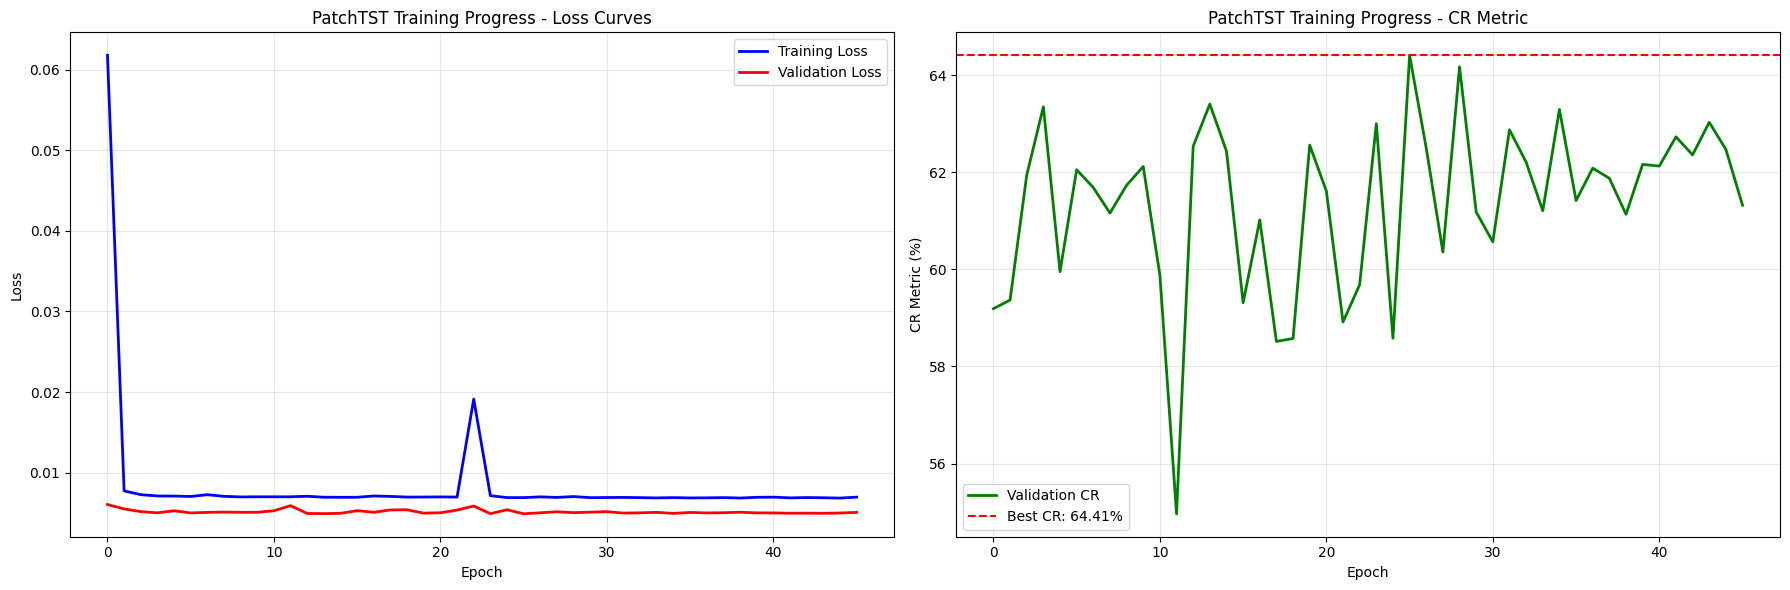


Model saved to: ./models/patchtst_16_point_best_model.pth
Best CR metric: 64.41%


In [10]:
# 绘制训练过程
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('PatchTST Training Progress - Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)


plt.subplot(1, 2, 2)
plt.plot(val_cr_scores, label='Validation CR', color='green', linewidth=2)
plt.axhline(y=early_stopping.best_cr, color='red', linestyle='--', 
           label=f'Best CR: {early_stopping.best_cr:.2f}%')
plt.xlabel('Epoch')
plt.ylabel('CR Metric (%)')
plt.title('PatchTST Training Progress - CR Metric')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 保存模型
model_save_path = f'{config.model_save_dir}/patchtst_16_point_best_model.pth'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_cr_scores': val_cr_scores,
    'best_cr': early_stopping.best_cr,
    'best_epoch': best_epoch,
    'config': config.__dict__,
    'feature_names': train_dataset.feature_names,
    'model_info': {
        'model_type': 'PatchTST',
        'patch_num': model.patch_num,
        'total_params': total_params,
        'input_size': config.input_size
    }
}, model_save_path)

print(f"\nModel saved to: {model_save_path}")
print(f"Best CR metric: {early_stopping.best_cr:.2f}%")

In [11]:
# 测试模型性能
def test_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            all_predictions.append(output.cpu().numpy())
            all_targets.append(target.cpu().numpy())
    
    predictions = np.concatenate(all_predictions, axis=0)
    targets = np.concatenate(all_targets, axis=0)
    
    return predictions, targets

print("=== Testing PatchTST Model ===")
predictions, targets = test_model(model, test_loader, device)

print(f"Prediction shape: {predictions.shape}")
print(f"Target shape: {targets.shape}")

# 计算每个预测步长的指标
print(f"\n=== Step-wise Test Results ===")
step_mse = []
step_mae = []
step_cr = []

for step in range(16):
    step_targets = targets[:, step]
    step_predictions = predictions[:, step]
    
    mse = mean_squared_error(step_targets, step_predictions)
    mae = mean_absolute_error(step_targets, step_predictions)
    cr = calculate_CR(step_targets, step_predictions)
    
    step_mse.append(mse)
    step_mae.append(mae)
    step_cr.append(cr)
    
    print(f"Step {step+1:2d}: MSE={mse:.6f}, MAE={mae:.6f}, CR={cr:.2f}%")

# 16个时间尺度的平均指标
mse_average_across_steps = np.mean(step_mse)
mae_average_across_steps = np.mean(step_mae)
rmse_average_across_steps = np.sqrt(mse_average_across_steps)
cr_average_across_steps = np.mean(step_cr)

print(f"\nAverage metrics across 16 time steps:")
print(f"Average MSE: {mse_average_across_steps:.6f}")
print(f"Average RMSE: {rmse_average_across_steps:.6f}")  
print(f"Average MAE: {mae_average_across_steps:.6f}")
print(f"Average CR: {cr_average_across_steps:.2f}%")

# 原有的整体指标（展平后计算）
mse_overall = mean_squared_error(targets.flatten(), predictions.flatten())
mae_overall = mean_absolute_error(targets.flatten(), predictions.flatten())
rmse_overall = np.sqrt(mse_overall)
cr_overall = calculate_CR(targets.flatten(), predictions.flatten())



print(f"\n=== Summary Statistics ===")
print(f"Average step-wise CR: {np.mean(step_cr):.2f}%")
print(f"Step-wise CR std: {np.std(step_cr):.2f}%")
print(f"Best step CR: {np.max(step_cr):.2f}% (Step {np.argmax(step_cr)+1})")
print(f"Worst step CR: {np.min(step_cr):.2f}% (Step {np.argmin(step_cr)+1})")

=== Testing PatchTST Model ===
Prediction shape: (2888, 16)
Target shape: (2888, 16)

=== Step-wise Test Results ===
Step  1: MSE=0.001740, MAE=0.026333, CR=85.97%
Step  2: MSE=0.004407, MAE=0.043127, CR=77.98%
Step  3: MSE=0.006899, MAE=0.055141, CR=72.55%
Step  4: MSE=0.008922, MAE=0.063737, CR=69.00%
Step  5: MSE=0.010659, MAE=0.071507, CR=65.52%
Step  6: MSE=0.012266, MAE=0.077881, CR=62.42%
Step  7: MSE=0.013864, MAE=0.083088, CR=59.73%
Step  8: MSE=0.015447, MAE=0.088546, CR=57.49%
Step  9: MSE=0.017058, MAE=0.093079, CR=55.48%
Step 10: MSE=0.018609, MAE=0.097481, CR=53.71%
Step 11: MSE=0.020254, MAE=0.102014, CR=51.82%
Step 12: MSE=0.021846, MAE=0.106373, CR=50.20%
Step 13: MSE=0.023299, MAE=0.110885, CR=48.23%
Step 14: MSE=0.024846, MAE=0.115456, CR=46.15%
Step 15: MSE=0.026560, MAE=0.120176, CR=44.09%
Step 16: MSE=0.028303, MAE=0.124445, CR=42.26%

Average metrics across 16 time steps:
Average MSE: 0.015936
Average RMSE: 0.126239
Average MAE: 0.086204
Average CR: 58.91%

=== S

In [12]:
# 保存详细结果
os.makedirs(config.results_dir, exist_ok=True)

# 保存预测结果
results_df = pd.DataFrame({
    'targets': targets.flatten(),
    'predictions': predictions.flatten(),
    'errors': targets.flatten() - predictions.flatten()
})
results_df.to_csv(f'{config.results_dir}/patchtst_16_point_predictions.csv', index=False)

# 保存性能指标
performance_summary = {
    'model_info': {
        'model_type': 'PatchTST',
        'patch_length': config.patch_len,
        'patch_count': model.patch_num,
        'd_model': config.d_model,
        'nhead': config.nhead,
        'num_layers': config.num_encoder_layers,
        'total_params': int(total_params),
        'input_features': int(config.input_size)
    },
    'overall_metrics': {
        'MSE': float(mse_overall),
        'RMSE': float(rmse_overall),
        'MAE': float(mae_overall),
        'CR': float(cr_overall)
    },
    'step_wise_metrics': {
        'step': list(range(1, 17)),
        'MSE': [float(x) for x in step_mse],
        'MAE': [float(x) for x in step_mae],
        'CR': [float(x) for x in step_cr]
    },
    'training_info': {
        'best_validation_cr': float(early_stopping.best_cr),
        'best_epoch': int(best_epoch),
        'total_epochs': len(train_losses),
        'final_lr': float(optimizer.param_groups[0]['lr']),
        'early_stopping_criterion': 'CR_based'
    },
    'hyperparameters': {
        'seq_length': config.seq_length,
        'pred_length': config.pred_length,
        'patch_len': config.patch_len,
        'batch_size': config.batch_size,
        'learning_rate': config.learning_rate,
        'dropout': config.dropout
    }
}

import json
with open(f'{config.results_dir}/patchtst_16_point_performance.json', 'w') as f:
    json.dump(performance_summary, f, indent=2)

# 创建详细报告
performance_report = f"""
# PatchTST Wind Power Prediction - Performance Report

## Model Architecture
- **Model Type**: PatchTST (Patching Time Series Transformer)
- **Input Sequence**: {config.seq_length} points ({config.seq_length * config.time_interval_minutes / 60:.1f} hours)
- **Prediction Length**: {config.pred_length} points ({config.pred_length * config.time_interval_minutes / 60:.1f} hours)
- **Patch Configuration**: {config.patch_len} points per patch, {model.patch_num} patches total
- **Model Dimension**: {config.d_model}
- **Attention Heads**: {config.nhead}
- **Encoder Layers**: {config.num_encoder_layers}
- **Total Parameters**: {total_params:,}

## Training Results
- **Best Validation CR**: {early_stopping.best_cr:.2f}% (Epoch {best_epoch})
- **Total Training Epochs**: {len(train_losses)}
- **Final Learning Rate**: {optimizer.param_groups[0]['lr']:.2e}

## Test Set Performance
- **Overall CR**: {cr_overall:.2f}%
- **RMSE**: {rmse_overall:.6f}
- **MAE**: {mae_overall:.6f}
- **MSE**: {mse_overall:.6f}

## Step-wise Performance Analysis
- **Average CR**: {np.mean(step_cr):.2f}%
- **CR Standard Deviation**: {np.std(step_cr):.2f}%
- **Best Step**: Step {np.argmax(step_cr)+1} (CR: {np.max(step_cr):.2f}%)
- **Worst Step**: Step {np.argmin(step_cr)+1} (CR: {np.min(step_cr):.2f}%)

## Detailed Step-wise Metrics
"""

for i in range(16):
    performance_report += f"\n### Step {i+1} ({(i+1)*15} minutes ahead)"
    performance_report += f"\n- **CR**: {step_cr[i]:.2f}%"
    performance_report += f"\n- **RMSE**: {np.sqrt(step_mse[i]):.6f}"
    performance_report += f"\n- **MAE**: {step_mae[i]:.6f}\n"

with open(f'{config.results_dir}/patchtst_16_point_report.md', 'w', encoding='utf-8') as f:
    f.write(performance_report)

print("\n=== Results Saved ===")
print(f"- Predictions: {config.results_dir}/patchtst_16_point_predictions.csv")
print(f"- Performance: {config.results_dir}/patchtst_16_point_performance.json")
print(f"- Report: {config.results_dir}/patchtst_16_point_report.md")
print(f"- Model: {model_save_path}")



=== Results Saved ===
- Predictions: ./results/patchtst_16_point_predictions.csv
- Performance: ./results/patchtst_16_point_performance.json
- Report: ./results/patchtst_16_point_report.md
- Model: ./models/patchtst_16_point_best_model.pth
